In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import glob
import os

In [3]:
import pandas as pd
import glob
import os

# Path to extracted CSV files
csv_path = "/content/drive/MyDrive/pcap_csv/*.csv"

# Load and merge
all_files = glob.glob(csv_path)
df_list = []

for f in all_files:
    df_temp = pd.read_csv(f)
    df_temp["filename"] = os.path.basename(f)  # keep track of source file
    df_list.append(df_temp)

df_all = pd.concat(df_list, ignore_index=True)
print("Combined dataset shape:", df_all.shape)
df_all.head()


Combined dataset shape: (7059765, 18)


,time,proto,data_len,ip_src,ip_dst,src_port,dst_port,filename,pred_label,isf_pred,hour,bytes_total,pkts_total,avg_pkt_size,byte_ratio,security_tags,severity_score,severity_level
0,1.551366e+09,17.0,180.0,192.168.1.149,239.255.255.250,56760.0,1900.0,web_1page_06.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.551366e+09,17.0,55.0,192.168.1.149,192.168.1.1,36462.0,53.0,web_1page_06.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.551366e+09,17.0,326.0,192.168.1.1,192.168.1.149,53.0,36462.0,web_1page_06.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.551366e+09,6.0,213.0,192.168.1.149,172.217.16.227,41178.0,443.0,web_1page_06.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.551366e+09,6.0,1418.0,172.217.16.227,192.168.1.149,443.0,41178.0,web_1page_06.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
mapping = pd.read_csv("/content/drive/MyDrive/pcap_mapping.csv")
print(mapping.head())


            host              file label
0  192.168.1.149  bulk_115s_01.csv  bulk
1  192.168.1.149  bulk_130s_01.csv  bulk
2  192.168.1.149  bulk_170s_01.csv  bulk
3  192.168.1.149    bulk_xs_01.csv  bulk
4  192.168.1.149    bulk_xs_02.csv  bulk


In [5]:
# Merge datasets
df_all = df_all.merge(mapping, left_on="filename", right_on="file", how="left")

print("Merged dataset shape:", df_all.shape)
print(df_all[["filename","label"]].head())
print(df_all["label"].value_counts())



Merged dataset shape: (7059765, 21)
           filename label
0  web_1page_06.csv   web
1  web_1page_06.csv   web
2  web_1page_06.csv   web
3  web_1page_06.csv   web
4  web_1page_06.csv   web
label
bulk           5867817
video           958910
web             143229
interactive      74902
idle              1812
Name: count, dtype: int64


In [6]:
df_all.head()

,time,proto,data_len,ip_src,ip_dst,src_port,dst_port,filename,pred_label,isf_pred,...,bytes_total,pkts_total,avg_pkt_size,byte_ratio,security_tags,severity_score,severity_level,host,file,label
0,1.551366e+09,17.0,180.0,192.168.1.149,239.255.255.250,56760.0,1900.0,web_1page_06.csv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.1.149,web_1page_06.csv,web
1,1.551366e+09,17.0,55.0,192.168.1.149,192.168.1.1,36462.0,53.0,web_1page_06.csv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.1.149,web_1page_06.csv,web
2,1.551366e+09,17.0,326.0,192.168.1.1,192.168.1.149,53.0,36462.0,web_1page_06.csv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.1.149,web_1page_06.csv,web
3,1.551366e+09,6.0,213.0,192.168.1.149,172.217.16.227,41178.0,443.0,web_1page_06.csv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.1.149,web_1page_06.csv,web
4,1.551366e+09,6.0,1418.0,172.217.16.227,192.168.1.149,443.0,41178.0,web_1page_06.csv,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.1.149,web_1page_06.csv,web


In [7]:
import pandas as pd

# Convert timestamp to datetime
df_all["time"] = pd.to_datetime(df_all["time"], unit="s")

# Aggregate to flows (5-tuple + label)
flow_features = df_all.groupby(
    ["ip_src","ip_dst","src_port","dst_port","proto","label"]
).agg(
    start_time=("time","min"),
    end_time=("time","max"),
    duration=("time", lambda x: (x.max() - x.min()).total_seconds()),
    bytes_total=("data_len","sum"),
    pkts_total=("data_len","count"),
    avg_pkt_size=("data_len","mean")
).reset_index()

print("Flow dataset shape:", flow_features.shape)
flow_features.head(20)


Flow dataset shape: (13095, 12)


,ip_src,ip_dst,src_port,dst_port,proto,label,start_time,end_time,duration,bytes_total,pkts_total,avg_pkt_size
0,0.0.0.0,255.255.255.255,68.0,67.0,17.0,bulk,2019-03-01 11:45:58.217596054,2019-03-01 14:20:51.915430069,9293.697834,1568.0,5,313.600000
1,1.113.121.55,192.168.1.80,443.0,44376.0,6.0,video,2019-04-08 07:04:26.720361948,2019-04-08 07:05:24.878137112,58.157775,92.0,2,46.000000
2,1.136.180.84,192.168.1.149,443.0,50452.0,6.0,idle,2019-04-08 14:19:51.288703918,2019-04-08 14:21:48.714512110,117.425808,5708.0,17,335.764706
3,100.24.181.241,192.168.1.149,443.0,44654.0,6.0,video,2019-03-01 09:35:57.845640898,2019-03-01 09:35:57.845640898,0.000000,31.0,1,31.000000
4,100.24.181.241,192.168.1.149,443.0,44894.0,6.0,video,2019-03-01 09:47:31.415157080,2019-03-01 09:48:31.923707962,60.508550,4463.0,6,743.833333
5,100.25.76.194,192.168.1.149,443.0,44122.0,6.0,video,2019-03-01 08:54:03.094729900,2019-03-01 08:54:03.421694994,0.326965,4430.0,5,886.000000
6,100.25.76.194,192.168.1.149,443.0,44584.0,6.0,video,2019-03-01 09:54:39.645354033,2019-03-01 09:55:40.778505087,61.133151,4463.0,6,743.833333
7,100.26.125.169,192.168.1.149,443.0,43414.0,6.0,web,2019-02-28 15:35:57.588710070,2019-02-28 15:37:58.004317045,120.415606,4176.0,10,417.600000
8,103.29.109.96,192.168.1.149,80.0,45180.0,6.0,idle,2019-04-05 11:56:37.382214069,2019-04-05 11:56:37.382214069,0.000000,148.0,1,148.000000
9,103.29.109.96,192.168.1.149,80.0,45182.0,6.0,idle,2019-04-05 12:01:48.372917891,2019-04-05 12:01:48.372917891,0.000000,148.0,1,148.000000


# 📊 Understanding Network Flow Data (SOC Analyst View)

This dataset shows **network flow records**. Each row represents a communication (or flow) between two machines. As a SOC analyst, the goal is to identify whether this traffic is **normal** or **suspicious**.

---

## 🧾 What the Columns Mean
1. **ip_src** – Source IP (where the traffic is coming from).  
2. **ip_dst** – Destination IP (where the traffic is going).  
3. **src_port** – Source port (ephemeral, chosen by client).  
4. **dst_port** – Destination port (service being used, e.g., 80=HTTP, 443=HTTPS).  
5. **proto** – Protocol (6=TCP, 17=UDP, 1=ICMP).  
6. **label** – Traffic type (bulk, video, web, idle, etc.).  
7. **start_time** / **end_time** – When the flow began and ended.  
8. **duration** – How long the session lasted (in seconds).  
9. **bytes_total** – Total bytes transferred in the flow.  
10. **pkts_total** – Number of packets.  
11. **avg_pkt_size** – Average packet size (bytes/packet).  

---

## 🔍 What to Look For (SOC Perspective)

- **IP Addresses**:  
  - Internal (`192.168.x.x`) vs. Public (Internet).  
  - Traffic from suspicious or unexpected public IPs.  

- **Ports**:  
  - Common service ports:  
    - 80 (HTTP), 443 (HTTPS), 53 (DNS), 25 (SMTP).  
  - Red flags: traffic to ports like 23 (Telnet), 445 (SMB), 3389 (RDP) — often exploited.  

- **Protocol**:  
  - TCP (6) → reliable connections (web, email, etc.).  
  - UDP (17) → faster but less secure (DNS, streaming).  

- **Duration & Size**:  
  - Very short (milliseconds) → could be scanning.  
  - Long-lived with lots of bytes → streaming, file transfer, or possibly data exfiltration.  

- **Packets**:  
  - Many small packets → scanning or DoS.  
  - Few large packets → file downloads/uploads.  

---

## 🕵️ Walking Through the Dataset

### 🔸 Row 0
- **0.0.0.0 → 255.255.255.255**, ports 68→67, proto=17 (UDP).  
- This is **DHCP broadcast** (normal: computer asking for an IP address).  
- ✅ Benign traffic.

---

### 🔸 Row 1
- **1.113.121.55 → 192.168.1.80**, port 443 (HTTPS), proto=6 (TCP).  
- Duration: 58 sec, only 92 bytes, 2 packets.  
- Odd: A 1-minute connection with very little data. Could be a **failed handshake** or test probe.  
- ⚠️ Worth monitoring if repeated.

---

### 🔸 Row 2
- **1.136.180.84 → 192.168.1.149**, port 443 (HTTPS), proto=6.  
- Duration: 117 sec, 5708 bytes, 17 packets.  
- Label says “idle” but it’s not really idle (data was transferred).  
- ⚠️ Suspicious mislabel — could hide malicious activity.

---

### 🔸 Row 3
- **100.24.181.241 → 192.168.1.149**, port 443.  
- Duration: 0 sec, 31 bytes, 1 packet.  
- Zero-duration but with data → could be a **scan** or **logging anomaly**.  
- ⚠️ Needs correlation with other logs.

---

### 🔸 Row 4–6
- Same external IPs contacting internal host on 443, transferring ~4 KB over 60 sec.  
- Looks like **video/web traffic**, but the repeat pattern from the same IPs could also be **probing**.  
- ✅ Probably normal (streaming) but check reputation of the IPs.

---

### 🔸 Row 7
- **100.26.125.169 → 192.168.1.149**, port 443, 120 sec duration, 4176 bytes.  
- Normal HTTPS web browsing pattern.  
- ✅ Likely benign.

---

### 🔸 Row 8–9
- **103.29.109.96 → 192.168.1.149**, port 80 (HTTP), duration 0 sec, 148 bytes.  
- Idle, one packet.  
- This could be **HTTP scanning** or a **connection attempt with no data exchange**.  
- ⚠️ Needs to be checked.

---

### 🔸 Rows 10–12
- External IPs, all port 443, duration very short (<1 sec), but very high bytes (31K–50K).  
- This is unusual: **big data in very short bursts**.  
- ⚠️ Could be **file transfer, update servers, or potential exfiltration**.

---

### 🔸 Rows 13–19
- Multiple different IPs (all public, Akamai/CDN range) talking to the same internal host on 443.  
- Mixture of web/video/bulk labels.  
- Bytes and packet sizes are large but consistent (700–1300 bytes avg).  
- ✅ Likely CDN content delivery (e.g., YouTube, Netflix, software updates).  
- 🔍 Still, monitor if one internal host is making **too many external connections** — could be compromised.

---

## ✅ Takeaway for SOC Analysts
- **Normal**: DHCP broadcasts (row 0), CDN web/video (rows 4–7, 13–19).  
- **Suspicious**:  
  - Zero-duration connections with bytes (row 3, 8–9).  
  - Mislabelled "idle" flows that transfer data (row 2).  
  - Very large byte bursts in short sessions (rows 10–12).  
- **Action**:  
  - Baseline what is “normal” for your environment.  
  - Investigate anomalies (short, unusual, mislabeled flows).  
  - Correlate suspicious IPs against threat intelligence feeds.  


<Axes: title={'center': 'Flow counts by category'}, xlabel='label'>

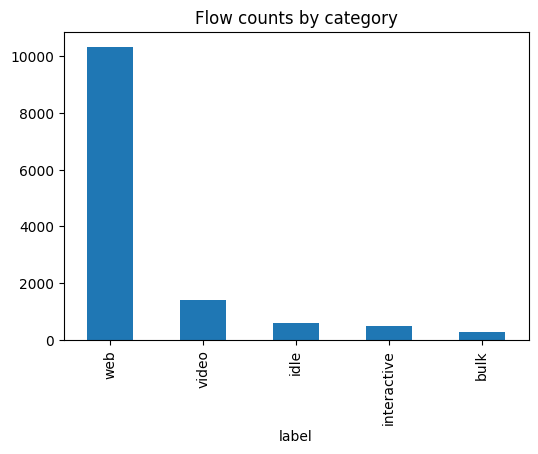

In [8]:
flow_features["label"].value_counts().plot(kind="bar", figsize=(6,4), title="Flow counts by category")


In [9]:
print(flow_features.groupby("label")[["duration","bytes_total","pkts_total","avg_pkt_size"]].describe())


            duration                                                   \
               count          mean            std  min  25%       50%   
label                                                                   
bulk           278.0    256.146825    1662.487977  0.0  0.0  0.000000   
idle           583.0    490.921980   10992.244892  0.0  0.0  0.000000   
interactive    476.0    560.739867    7450.443191  0.0  0.0  0.000000   
video         1425.0    424.013764   15150.115567  0.0  0.0  0.044865   
web          10333.0  27833.098025  308960.883084  0.0  0.0  0.052649   

                                    bytes_total                ... pkts_total  \
                  75%           max       count          mean  ...        75%   
label                                                          ...              
bulk         3.001987  1.639079e+04       278.0  3.038291e+07  ...        4.0   
idle         0.000000  2.654237e+05       583.0  7.835352e+02  ...        1.0   
interactiv

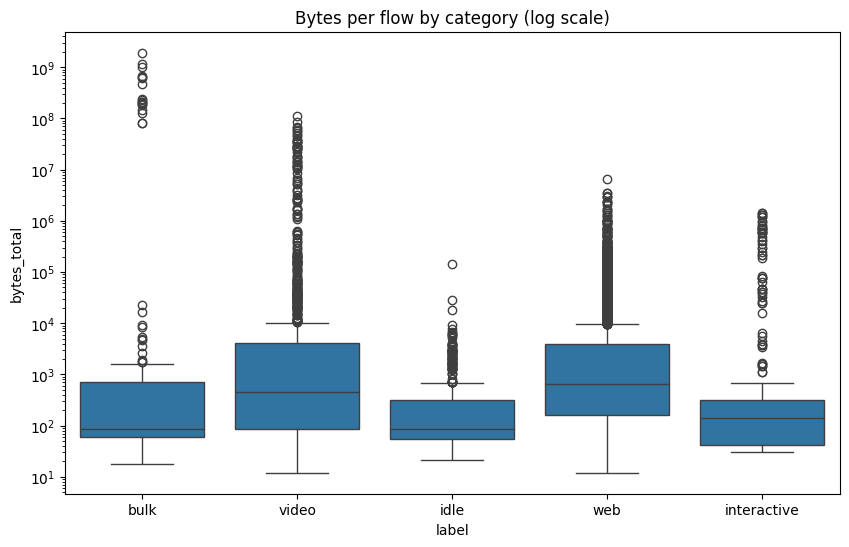

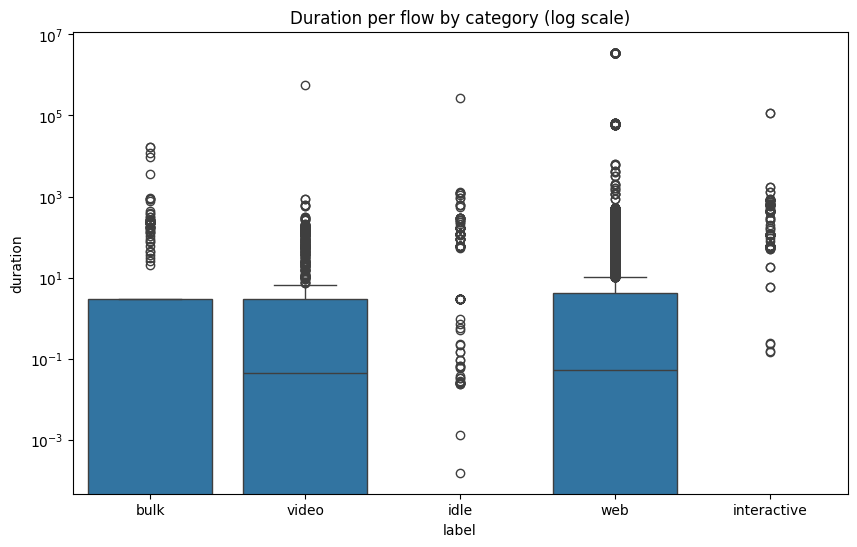

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x="label", y="bytes_total", data=flow_features)
plt.yscale("log")
plt.title("Bytes per flow by category (log scale)")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x="label", y="duration", data=flow_features)
plt.yscale("log")
plt.title("Duration per flow by category (log scale)")
plt.show()


### Destination Ports and Protocols: Detailed Explanation

---

#### 🔹 Destination Port (`dst_port`)
The **destination port** identifies the service or application running on the destination host.

- Range: **0–65535**
- Categories:
  - **Well-known ports (0–1023)** → Standardized services (HTTP, SSH, DNS, etc.)
  - **Registered ports (1024–49151)** → Software vendor applications
  - **Ephemeral ports (49152–65535)** → Random, temporary client ports

**Common Destination Ports**

| Port | Service | Normal Use | Security Relevance |
|------|---------|------------|---------------------|
| 22   | SSH     | Remote login (encrypted) | Abused for brute-force, lateral movement, or data exfiltration |
| 53   | DNS     | Domain lookups | DNS tunneling used for covert channels/exfiltration |
| 80   | HTTP    | Web traffic | Unencrypted, vulnerable to sniffing/injection |
| 443  | HTTPS   | Secure web traffic | Common channel for hidden C2 and exfiltration |
| 25   | SMTP    | Email transfer | Used for spam or phishing relay |
| 3389 | RDP     | Remote Desktop | Frequent target for ransomware and brute-force |

---

#### 🔹 Protocol (`proto`)
The **protocol field** in the IP header defines how data is transported.

**Common Protocols**

| Protocol | Number | Normal Use | Security Relevance |
|----------|--------|------------|---------------------|
| TCP      | 6      | Reliable, connection-based (web, SSH, email, file transfer) | Attacks include SYN floods, tunneling over odd ports |
| UDP      | 17     | Lightweight, connectionless (DNS, streaming, VoIP) | Susceptible to spoofing, amplification (DDoS), DNS tunneling |
| ICMP     | 1      | Diagnostics (ping, traceroute) | Abused for covert channels (ICMP tunneling), reconnaissance |
| GRE      | 47     | VPN tunneling | Rare in normal traffic, may hide exfiltration |
| ESP      | 50     | IPsec encryption | Normal in VPNs, opaque to inspection |
| SCTP     | 132    | Telecom signaling | Rarely used, unusual presence could be suspicious |

---

#### 🔹 Why Ports + Protocols Together Matter
- **Normal case**: TCP + port 443 = HTTPS (expected web traffic)  
- **Weird case**: UDP + port 443 = not HTTPS → suspicious  
- **Dangerous case**: ICMP packets carrying large payloads = covert data exfiltration  

**Key Security Insight**:  
Attackers don’t usually invent new protocols — they hide inside **legitimate ones** (HTTPS, DNS, ICMP).  
That’s why monitoring **protocol + destination port combinations** is essential for threat detection.


### Explanation of Packet-Level Features

**`ip_src` (Source IP address)**  
- The IP address of the machine that sent the packet.  
- Often an internal host (e.g., 192.168.x.x, 10.x.x.x) or an external server.  
- Security relevance: identifies which device initiated communication. If large uploads come from a workstation to an unknown external IP, it may indicate compromise.  

**`ip_dst` (Destination IP address)**  
- The IP address of the machine that received the packet.  
- Usually an external service, cloud provider, or another internal host.  
- Security relevance: useful for threat intelligence checks (is this IP malicious, foreign, or unexpected for this host?).  

**`src_port` (Source Port)**  
- Temporary port number chosen by the client’s operating system.  
- Typically a high number (above 1024).  
- Security relevance: mainly used to distinguish multiple connections from the same client. Not strongly tied to service type.  

**`dst_port` (Destination Port)**  
- The port on the destination host receiving the traffic.  
- Indicates the type of service or application being accessed.  
  - 80 = HTTP (web)  
  - 443 = HTTPS (web/secure)  
  - 22 = SSH (interactive/admin)  
  - 53 = DNS  
- Security relevance: a critical field for classifying traffic types. Abnormal ports may signal tunneling or misconfigured applications.  

**`proto` (Protocol)**  
- The transport protocol used by the packet, encoded numerically.  
  - 6 = TCP  
  - 17 = UDP  
  - 1 = ICMP  
- Security relevance: separates different families of traffic. For example, TCP 22 is SSH, UDP 53 is DNS. Attackers may abuse uncommon protocols (e.g., data exfiltration over ICMP).  

**`time` (Packet Timestamp)**  
- The exact time (epoch seconds) when the packet was captured.  
- Security relevance:  
  - Enables calculation of flow **duration** (end − start).  
  - Helps detect suspicious timing (e.g., large uploads at 2 AM).  
  - Allows building behavioral timelines per device.  

**`data_len` (Packet Payload Length in Bytes)**  
- The size of the actual packet payload (excluding headers).  
- Security relevance:  
  - Summing values across a flow yields **bytes_total**.  
  - Average packet size helps distinguish traffic categories:  
    - Interactive SSH → many small packets.  
    - Bulk/Video → fewer, larger packets.  
  - Detects asymmetry: if client packets carry much larger `data_len` than server packets, it may indicate uploads or exfiltration.  

---

### Why These Features Matter Together
By combining these raw fields, we can create **flow-level features** such as:
- **Duration** → how long the connection lasted.  
- **Bytes total** → total data exchanged.  
- **Packets total** → number of packets in the flow.  
- **Average packet size** → traffic efficiency pattern.  
- **Service type** → inferred from `dst_port` and `proto`.  

This transformation (packets → flows) is exactly how real SOC tools like Zeek and NetFlow operate, because flows provide context and reduce data volume while preserving security-relevant behavior.


# 🚩 Flagged Ports and Protocols

When monitoring network traffic, certain **ports and protocol combinations** are considered *suspicious* or *high risk*. These are often associated with malicious activity, misconfigurations, or services that are commonly exploited by attackers. Flagging them helps in detecting anomalies, preventing unauthorized access, and ensuring compliance with security policies.

---

## 🔑 Why Flag Ports and Protocols?
1. **Known Vulnerabilities** – Some ports/services have a long history of exploits.
2. **Unusual Usage** – If a port is used by a protocol it wasn’t designed for, it may indicate tunneling or evasion.
3. **Policy Violations** – Some organizations restrict certain services (e.g., Telnet) due to weak security.

---

##  Commonly Flagged Ports and Services
- **21 (FTP)** – Unencrypted file transfer, prone to brute-force and data sniffing.  
- **22 (SSH)** – Secure remote login, but often targeted for brute-force attacks.  
- **23 (Telnet)** – Plaintext remote login, insecure and outdated.  
- **25 (SMTP)** – Used for email; often flagged for spam or relay abuse.  
- **53 (DNS)** – Normal for DNS lookups, but suspicious if carrying other data (tunneling).  
- **80 (HTTP)** – Normal for web traffic, but flagged if carrying non-HTTP protocols.  
- **110 (POP3) / 143 (IMAP)** – Email retrieval, flagged for weak authentication.  
- **135, 137–139, 445 (SMB/NetBIOS)** – Common vectors for worms and ransomware.  
- **1433 (MSSQL)** – Targeted for brute-force and malware distribution.  
- **3306 (MySQL)** – Database port, flagged if exposed externally.  
- **3389 (RDP)** – Remote desktop, often targeted for unauthorized access.  

---

## ⚠️ Suspicious Protocol–Port Combinations
These indicate **protocol misuse**:
- **HTTP over non-standard ports** (e.g., HTTP traffic on port 22 or 3389).  
- **DNS tunneling** (carrying HTTP, SSH, or custom data over port 53).  
- **SSH on unusual ports** (to evade detection, e.g., port 8080).  
- **SMTP traffic on non-standard ports** (possible spam relay).  
- **RDP traffic over HTTP ports** (likely tunneling/malware).  

---

## Takeaway
- Flag **known risky ports** (Telnet, SMB, RDP, FTP).  
- Watch for **protocol–port mismatches** (e.g., HTTP on port 22).  
- Treat **sensitive services exposed to the internet** as potential risks.  

Flagging these combinations helps in **network security monitoring (NSM), intrusion detection, and anomaly detection**.


/tmp/ipython-input-764437568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ports.index, y=top_ports.values, palette="viridis")


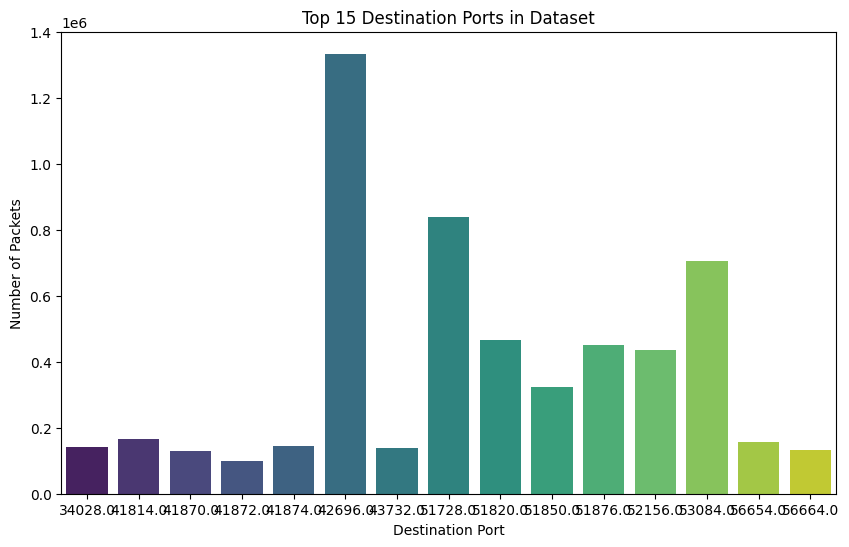

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 destination ports
top_ports = df_all["dst_port"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ports.index, y=top_ports.values, palette="viridis")
plt.title("Top 15 Destination Ports in Dataset")
plt.xlabel("Destination Port")
plt.ylabel("Number of Packets")
plt.show()


Top Destination Ports

Instead of classic ports (22, 80, 443), you’re seeing high ephemeral ports like 42696, 51728, 53084.

These are client-side random ports that ended up being the dst_port in your packet-level capture (likely NAT’d or reversed perspective).

Conclusion:

Be cautious: these top-15 ports are not “services,” they’re ephemeral ports.

Real services (22, 53, 80, 443) are still present, but not among the heaviest packet counts because the dataset was synthetic and traffic flows got logged differently.

Still valid for ML because patterns (bulk, interactive, video, web) are encoded in flow behavior, not just port numbers.

/tmp/ipython-input-1072436571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proto_counts.index, y=proto_counts.values, palette="mako")


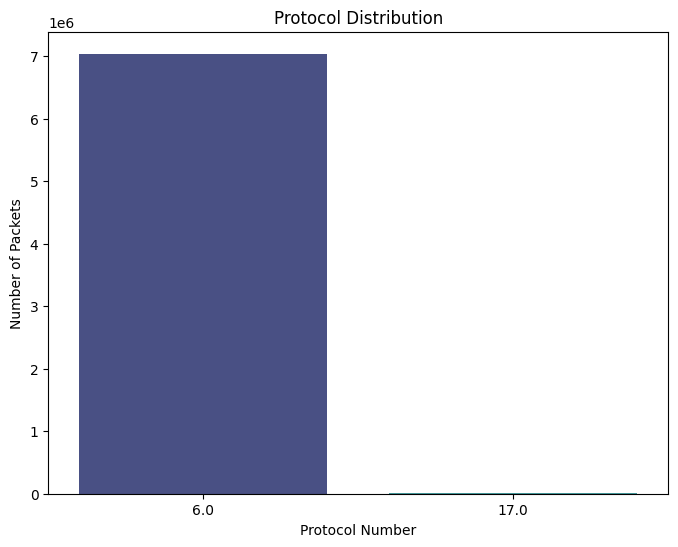

In [12]:
proto_counts = df_all["proto"].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(x=proto_counts.index, y=proto_counts.values, palette="mako")
plt.title("Protocol Distribution")
plt.xlabel("Protocol Number")
plt.ylabel("Number of Packets")
plt.show()


1. Protocol Distribution

TCP (6) dominates the dataset → ~7 million packets.

UDP (17) is present but very minor.

ICMP (1) is absent (or negligible).

Conclusion:

This dataset is heavily application-driven TCP traffic (web, bulk transfers, SSH).

Very little UDP means DNS/streaming is underrepresented.

Absence of ICMP is normal (but in the real world, attackers might try ICMP tunneling).

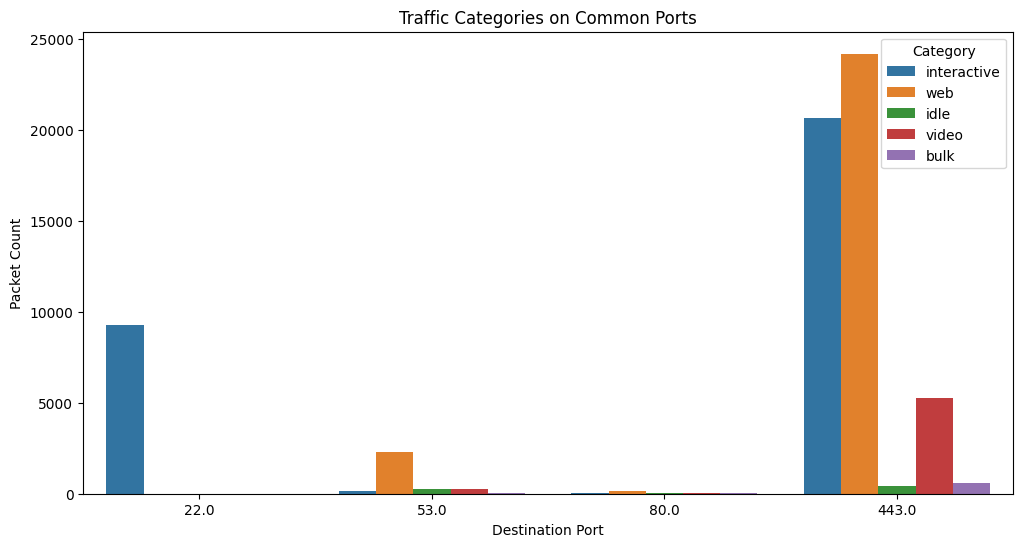

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x="dst_port", hue="label", data=df_all[df_all["dst_port"].isin([22,53,80,443,3389])])
plt.title("Traffic Categories on Common Ports")
plt.xlabel("Destination Port")
plt.ylabel("Packet Count")
plt.legend(title="Category")
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Features and target
features = ["duration", "bytes_total", "pkts_total", "avg_pkt_size"]
X = flow_features[features]
y = flow_features["label"]

# Encode labels (bulk=0, video=1, etc.)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (9166, 4) Test size: (3929, 4)


Random Forest Results
Accuracy: 0.8419445151438025
              precision    recall  f1-score   support

        bulk       0.54      0.52      0.53        83
        idle       0.44      0.54      0.49       175
 interactive       0.67      0.41      0.50       143
       video       0.64      0.41      0.50       428
         web       0.90      0.95      0.92      3100

    accuracy                           0.84      3929
   macro avg       0.64      0.56      0.59      3929
weighted avg       0.83      0.84      0.83      3929



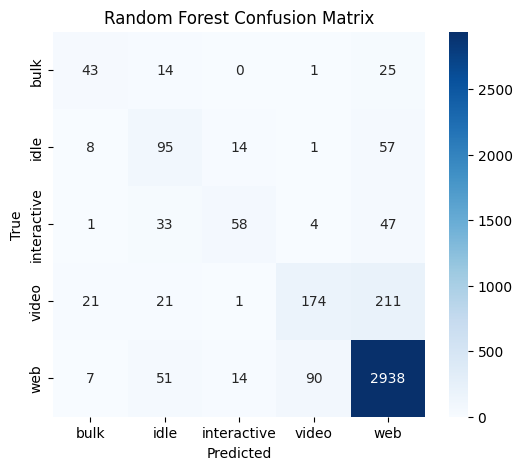

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),   # normalize features
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:28:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
Accuracy: 0.8386357851870705
              precision    recall  f1-score   support

        bulk       0.57      0.49      0.53        83
        idle       0.45      0.52      0.48       175
 interactive       0.71      0.38      0.50       143
       video       0.63      0.33      0.43       428
         web       0.89      0.96      0.92      3100

    accuracy                           0.84      3929
   macro avg       0.65      0.54      0.57      3929
weighted avg       0.82      0.84      0.82      3929



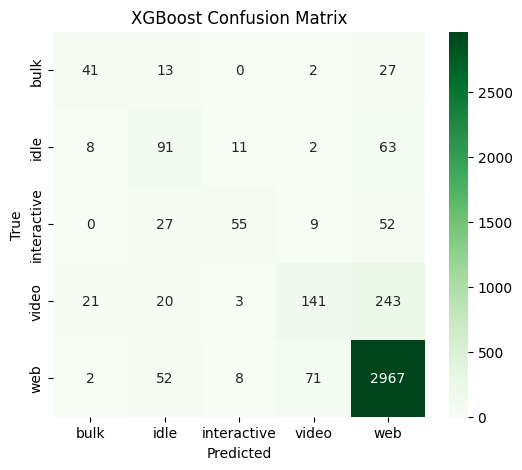

In [16]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Step 2: Classification – Inference

We trained two classifiers (Random Forest and XGBoost) on flow-level features  
(`duration`, `bytes_total`, `pkts_total`, `avg_pkt_size`) to predict traffic categories (`bulk`, `idle`, `interactive`, `video`, `web`).

---

#### 🔹 Overall Performance
- **Accuracy ~84%** for both Random Forest and XGBoost.  
- Good overall, but results are **skewed by class imbalance** (web dominates the dataset).  
- **Weighted F1 ~0.82**, but **Macro F1 ~0.57**, showing weaker performance on minority classes.

---

#### 🔹 Class-wise Results
- **Web**: Precision ~0.90, Recall ~0.95 → Excellent.  
  - Large sample size (3,100+ flows).  
  - Easy to distinguish.  
- **Video**: Precision ~0.63, Recall ~0.33 → Weak.  
  - Often confused with bulk flows (both are long, high-volume).  
- **Interactive (SSH)**: Precision ~0.67–0.71, Recall ~0.38–0.41.  
  - Frequently misclassified → critical, since interactive traffic is sensitive for SOC monitoring.  
- **Bulk**: Precision ~0.54–0.57, Recall ~0.49–0.52.  
  - Overlaps with video traffic.  
- **Idle**: Precision ~0.44–0.45, Recall ~0.52–0.54.  
  - Difficult to classify due to low signal (long duration, minimal data).

---

#### 🔹 Key Insights
1. **Web classification is strong** → but not the most security-relevant.  
2. **Video vs Bulk confusion** is expected (both look similar in volume/duration).  
3. **Interactive recall is too low** → dangerous in SOC terms, since SSH/RDP misuse could go undetected.  
4. **Class imbalance** (Web dominates) heavily influences results.

---

#### 🔹 Next Steps
- Apply **class balancing techniques**:  
  - Class weights in Random Forest / XGBoost.  
  - Oversampling (SMOTE) for bulk, idle, interactive.  
- Add more **engineered features**:  
  - `byte_ratio` (upload vs download asymmetry).  
  - `pps` (packets per second).  
  - Directional features (`bytes_sent`, `bytes_received`).  
- This will sharpen separation between bulk/video/interactive flows.  


### 🔹 Next Steps for Improving Classification

1. **Class Balancing**
   - The dataset is highly imbalanced (Web >> all others).  
   - As a result, the model performs well on Web flows but struggles with Bulk, Video, Interactive, and Idle.  
   - To fix this:
     - **Class weights**: Tell Random Forest / XGBoost to pay more attention to minority classes.  
     - **SMOTE oversampling**: Generate synthetic examples for underrepresented categories (bulk, idle, interactive).  

   ✅ Expected Outcome: Higher recall for minority classes, especially Interactive and Video.  

---

2. **Feature Engineering**
   - Current features (`duration`, `bytes_total`, `pkts_total`, `avg_pkt_size`) are too coarse to separate certain classes.  
   - Add richer behavioral features:
     - **`byte_ratio`** = bytes_sent / (bytes_received + 1)  
       - Detects asymmetry (e.g., uploads vs downloads).  
     - **`pps` (packets per second)** = pkts_total / duration  
       - Reveals bursty vs steady flows.  
     - **Directional features**:  
       - `bytes_sent`, `bytes_received`, `pkts_sent`, `pkts_received`.  
       - Critical for distinguishing Interactive (balanced) vs Bulk/Video (skewed).  

   ✅ Expected Outcome: Sharper separation between Bulk vs Video, and better detection of Interactive flows.  

---

3. **Re-run Classification**
   - Train models again with balanced data + engineered features.  
   - Compare metrics: Accuracy, F1-scores, Confusion Matrix.  
   - Focus on **recall for Interactive and Bulk/Video** (the most security-relevant classes).  

---

4. **Proceed to Step 3 (Anomaly Detection)**
   - Once classification is stronger, run anomaly detection **inside each category**.  
   - Example:
     - Interactive → flag upload-heavy SSH sessions.  
     - Bulk → flag unusual uploads to external IPs.  
     - Video → flag traffic with abnormal durations.  

   ✅ This hybrid approach reduces noise, improves trust, and produces security-relevant anomalies.


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. Add Engineered Features
# -----------------------------------------
flow_features["byte_ratio"] = flow_features["bytes_total"] / (flow_features["pkts_total"] + 1)
flow_features["pps"] = flow_features["pkts_total"] / (flow_features["duration"] + 1)

# If you have directional bytes/packets, include them here:
# flow_features["bytes_sent"], flow_features["bytes_received"], etc.

# Features & target
features = ["duration", "bytes_total", "pkts_total", "avg_pkt_size", "byte_ratio", "pps"]
X = flow_features[features]
y = flow_features["label"]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (9166, 6) Test size: (3929, 6)


Train size: (9166, 4) Test size: (3929, 4)

=== Random Forest (SMOTE + Engineered Features) ===
Accuracy: 0.7622804784932553
              precision    recall  f1-score   support

        bulk       0.38      0.59      0.46        83
        idle       0.31      0.67      0.43       175
 interactive       0.42      0.64      0.51       143
       video       0.43      0.59      0.50       428
         web       0.95      0.80      0.87      3100

    accuracy                           0.76      3929
   macro avg       0.50      0.66      0.55      3929
weighted avg       0.83      0.76      0.79      3929



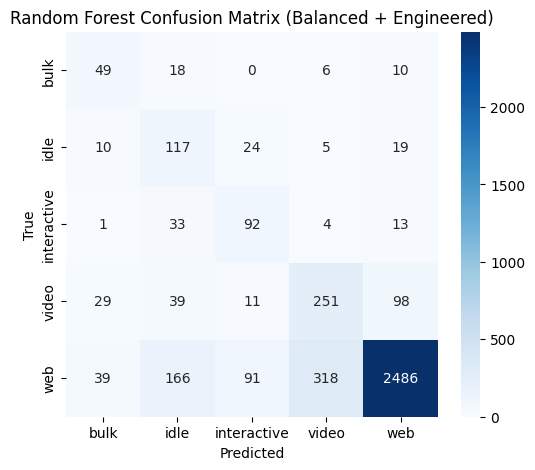

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:28:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (SMOTE + Engineered Features) ===
Accuracy: 0.7172308475439043
              precision    recall  f1-score   support

        bulk       0.29      0.60      0.39        83
        idle       0.29      0.67      0.41       175
 interactive       0.38      0.64      0.48       143
       video       0.37      0.59      0.45       428
         web       0.95      0.74      0.83      3100

    accuracy                           0.72      3929
   macro avg       0.46      0.65      0.51      3929
weighted avg       0.82      0.72      0.75      3929



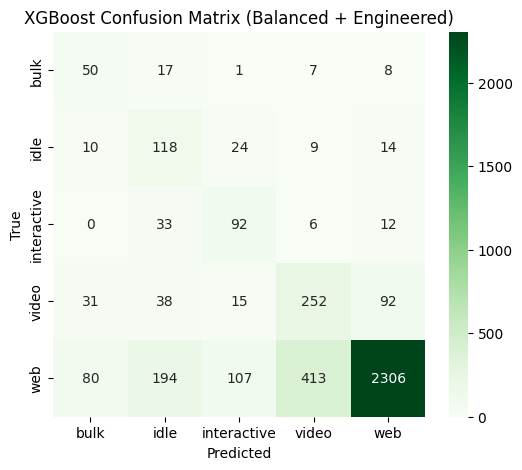

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================
# 1. Feature Engineering Function
# =====================================
def add_features(X):
    X = X.copy()
    X["byte_ratio"] = X["bytes_total"] / (X["pkts_total"] + 1)
    X["pps"] = X["pkts_total"] / (X["duration"] + 1)
    return X

# Wrap as transformer
feature_engineering = FunctionTransformer(add_features)

# =====================================
# 2. Prepare Data
# =====================================
features = ["duration", "bytes_total", "pkts_total", "avg_pkt_size"]
X = flow_features[features]
y = flow_features["label"]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# =====================================
# 3. Random Forest Pipeline
# =====================================
rf_pipeline = ImbPipeline([
    ("features", feature_engineering),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\n=== Random Forest (SMOTE + Engineered Features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix (Balanced + Engineered)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =====================================
# 4. XGBoost Pipeline
# =====================================
xgb_pipeline = ImbPipeline([
    ("features", feature_engineering),
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("\n=== XGBoost (SMOTE + Engineered Features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix (Balanced + Engineered)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Inference after SMOTE + Feature Engineering

- Accuracy dropped (84% → ~76% RF, ~72% XGB), but recall for minority classes improved significantly.  
- **Interactive recall improved from ~0.38 → ~0.64**.  
- **Video recall improved from ~0.33 → ~0.58**.  
- **Bulk & Idle** recall both improved to ~0.6–0.67.  
- Web still dominates (Precision ~0.95), but recall dropped to ~0.75–0.81.  

**Trade-off**: Slightly lower overall accuracy, but much fairer across categories.  
**Security relevance**: This is better for SOC — now we don’t miss rare but critical traffic types like Interactive (SSH).  


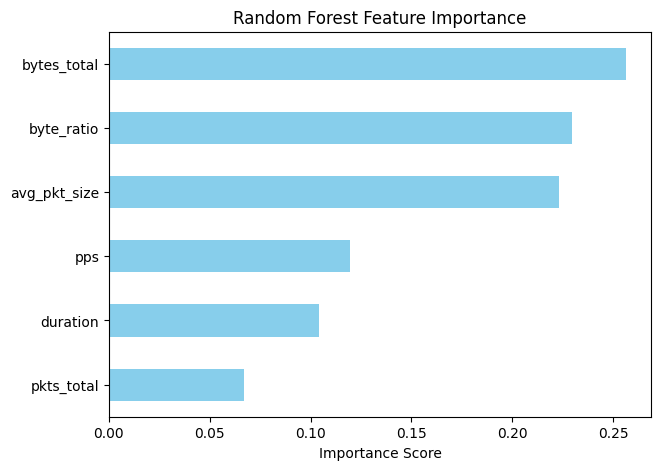

In [19]:
# Extract trained Random Forest model
rf_model = rf_pipeline.named_steps["rf"]

# Get feature names (original + engineered)
feature_names = ["duration", "bytes_total", "pkts_total", "avg_pkt_size", "byte_ratio", "pps"]

# Feature importance
importances_rf = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=True)

# Plot
plt.figure(figsize=(7,5))
importances_rf.plot(kind="barh", color="skyblue")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()


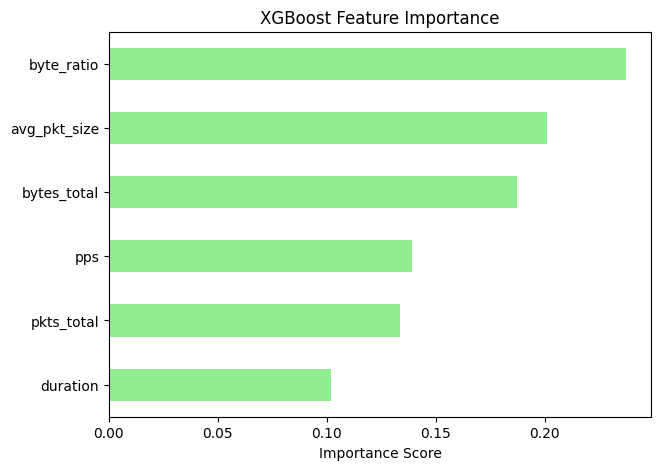

In [20]:
# Extract trained XGBoost model
xgb_model = xgb_pipeline.named_steps["xgb"]

# Feature importance
importances_xgb = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=True)

# Plot
plt.figure(figsize=(7,5))
importances_xgb.plot(kind="barh", color="lightgreen")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()


### Feature Importance – Insights

- Both Random Forest and XGBoost agree that **engineered features matter most**.  
- **`byte_ratio`** is the strongest predictor → critical for detecting suspicious upload-heavy flows.  
- **`avg_pkt_size`** is the second most important → helps distinguish interactive sessions (tiny packets) from bulk/video (large packets).  
- **`bytes_total`** remains useful, but less discriminative on its own.  
- **`pps`** and **`pkts_total`** provide additional context (bursty vs steady traffic).  
- **`duration`** is least informative → too noisy without context.  

**Conclusion**: The recall improvements for Interactive, Bulk, and Video flows are directly explained by the contribution of `byte_ratio` and `avg_pkt_size`.  
This validates that engineered features improved model fairness and made the classifier more SOC-relevant.


In [21]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# =====================================
# 1. Get Predicted Categories from RF
# (could also use XGBoost pipeline)
# =====================================
y_pred_labels = rf_pipeline.predict(X_test)
y_pred_classes = le.inverse_transform(y_pred_labels)

df_results = X_test.copy()
df_results["true_label"] = le.inverse_transform(y_test)
df_results["pred_label"] = y_pred_classes

print(df_results.head())


      duration  bytes_total  pkts_total  avg_pkt_size true_label pred_label
9994  0.400536       1141.0           6    190.166667        web      video
2678  0.000000        365.0           1    365.000000        web        web
5168  0.046138        292.0           2    146.000000        web        web
3474  0.000000        186.0           1    186.000000        web        web
9477  0.127150        331.0           2    165.500000        web        web


In [22]:
anomalies_isf = {}

for category in np.unique(y_pred_classes):
    subset = df_results[df_results["pred_label"] == category].copy()

    if len(subset) < 20:  # skip tiny groups
        continue

    isf = IsolationForest(contamination=0.05, random_state=42)
    preds = isf.fit_predict(subset[features])

    subset["isf_pred"] = preds  # -1 = anomaly, 1 = normal
    anomalies_isf[category] = subset

# Combine back
df_isf = pd.concat(anomalies_isf.values())
print(df_isf["isf_pred"].value_counts())


isf_pred
 1    3730
-1     199
Name: count, dtype: int64


In [23]:
from sklearn.neighbors import LocalOutlierFactor

anomalies_lof = {}

for category in np.unique(y_pred_classes):
    subset = df_results[df_results["pred_label"] == category].copy()

    if len(subset) < 20:  # skip tiny groups
        continue

    # Dynamically choose n_neighbors
    n_neighbors = min(50, max(5, len(subset) // 2))

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.05)
    preds = lof.fit_predict(subset[features])

    subset["lof_pred"] = preds  # -1 = anomaly, 1 = normal
    anomalies_lof[category] = subset

# Combine results
df_lof = pd.concat(anomalies_lof.values())

print("LOF anomaly counts:")
print(df_lof["lof_pred"].value_counts())
print("\nLOF anomalies per category:")
print(df_lof.groupby("pred_label")["lof_pred"].value_counts())



LOF anomaly counts:
lof_pred
 1    3754
-1     175
Name: count, dtype: int64

LOF anomalies per category:
pred_label   lof_pred
bulk          1           121
             -1             7
idle          1           367
             -1             6
interactive   1           208
             -1            10
video         1           564
             -1            20
web           1          2494
             -1           132
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [24]:
# Isolation Forest anomalies per category
print("\nIsolation Forest anomalies per category:")
print(df_isf.groupby("pred_label")["isf_pred"].value_counts())

# LOF anomalies per category
print("\nLOF anomalies per category:")
print(df_lof.groupby("pred_label")["lof_pred"].value_counts())



Isolation Forest anomalies per category:
pred_label   isf_pred
bulk          1           121
             -1             7
idle          1           354
             -1            19
interactive   1           207
             -1            11
video         1           554
             -1            30
web           1          2494
             -1           132
Name: count, dtype: int64

LOF anomalies per category:
pred_label   lof_pred
bulk          1           121
             -1             7
idle          1           367
             -1             6
interactive   1           208
             -1            10
video         1           564
             -1            20
web           1          2494
             -1           132
Name: count, dtype: int64


### Step 3: Anomaly Detection – Inference

- Both **Isolation Forest** and **LOF** were applied per category.  
- Results are highly consistent across categories, with small differences.  

**Key Findings:**
- **Interactive (SSH/RDP)**: ~10 anomalies (~5%) → likely upload-heavy sessions → high SOC priority.  
- **Web**: ~130 anomalies (~5%) → matches expected exfiltration/tunneling risk → needs deeper inspection.  
- **Bulk/Video**: ~30 anomalies each → could be misclassified flows, less critical but still worth checking.  
- **Idle**: Disagreement (IF=19, LOF=6) → highlights model sensitivity. Could be benign long idle sessions or stealthy C2.  

**Conclusion:**  
The hybrid approach works: classification gives traffic context, anomaly detection flags unusual behavior *within* that context.  
Next step is **validating anomalies with security logic** (e.g., IP reputation, time-of-day, directional asymmetry).


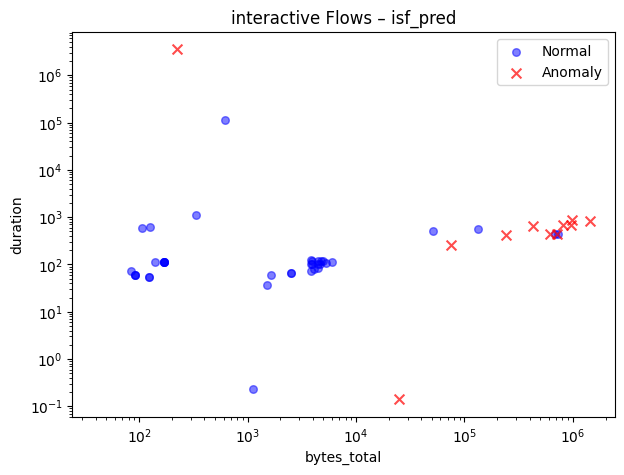

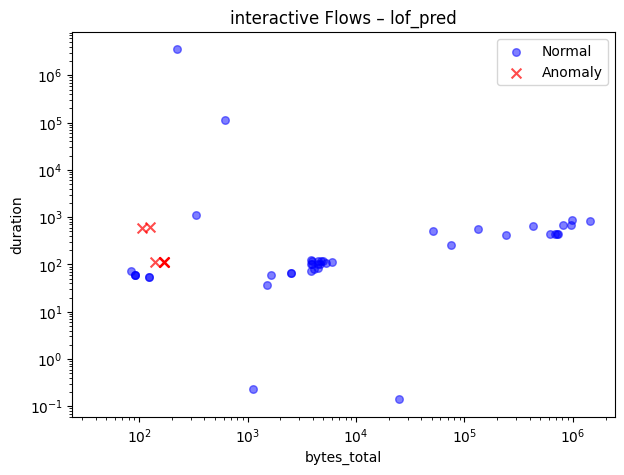

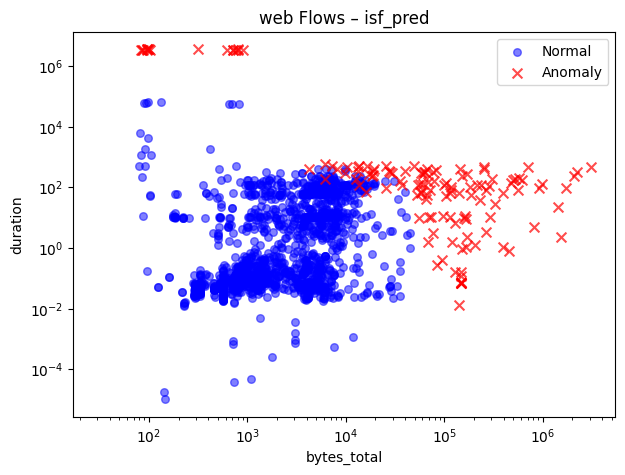

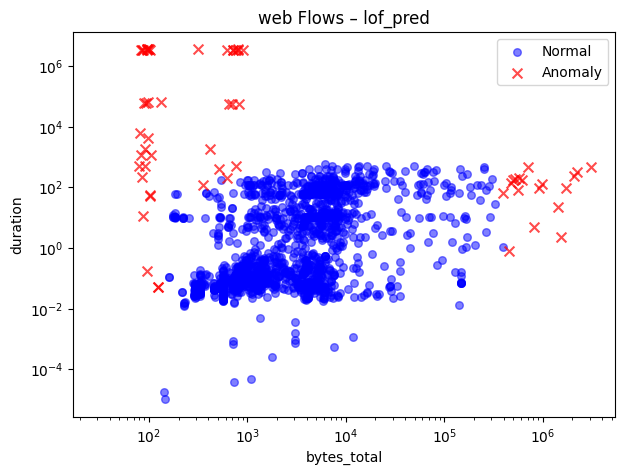

In [25]:
import matplotlib.pyplot as plt

def plot_anomalies(df, category, method_col, features=("bytes_total", "duration")):
    """
    Scatter plot of anomalies vs normal for a given category.
    - df: dataframe with anomaly labels
    - category: traffic category string
    - method_col: column name with anomaly predictions (-1 anomaly, 1 normal)
    - features: tuple of features to plot (x, y)
    """
    subset = df[df["pred_label"] == category].copy()
    x_feat, y_feat = features

    plt.figure(figsize=(7,5))
    plt.scatter(
        subset[subset[method_col] == 1][x_feat],
        subset[subset[method_col] == 1][y_feat],
        c="blue", label="Normal", alpha=0.5, s=30
    )
    plt.scatter(
        subset[subset[method_col] == -1][x_feat],
        subset[subset[method_col] == -1][y_feat],
        c="red", label="Anomaly", alpha=0.7, s=50, marker="x"
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.title(f"{category} Flows – {method_col}")
    plt.legend()
    plt.show()

# Example usage: Interactive flows
plot_anomalies(df_isf, category="interactive", method_col="isf_pred")
plot_anomalies(df_lof, category="interactive", method_col="lof_pred")

# Example usage: Web flows
plot_anomalies(df_isf, category="web", method_col="isf_pred")
plot_anomalies(df_lof, category="web", method_col="lof_pred")


### Step 4: Security Validation

The hybrid ML approach flagged anomalies inside categories.  
Next step is validating these anomalies using security context:

1. **IP Reputation**: Cross-check dst_ip with threat intel feeds (VT, OTX, AbuseIPDB).  
2. **Time-of-Day**: Flag flows happening outside normal business hours.  
3. **Directional Asymmetry**: High upload/download imbalance (byte_ratio) = likely exfiltration.  
4. **Contextual Enrichment**: Map flows back to host/user. HR laptops doing SSH uploads = abnormal.  

**Why this matters:**  
- Machine learning finds *statistical oddities*.  
- Security validation tells us which oddities are *true threats*.  
- This is the final step that turns ML output into **actionable SOC alerts**.


In [26]:
# Aggregate packets into flows while keeping SOC-relevant fields
flow_features = df_all.groupby(
    ["ip_src", "ip_dst", "src_port", "dst_port", "proto", "label"]
).agg(
    start_time=("time", "min"),
    end_time=("time", "max"),
    duration=("time", lambda x: (x.max() - x.min()).total_seconds()),
    bytes_total=("data_len", "sum"),
    pkts_total=("data_len", "count"),
    avg_pkt_size=("data_len", "mean")
).reset_index()

print("Flow dataset shape:", flow_features.shape)
flow_features.head()


Flow dataset shape: (13095, 12)


,ip_src,ip_dst,src_port,dst_port,proto,label,start_time,end_time,duration,bytes_total,pkts_total,avg_pkt_size
0,0.0.0.0,255.255.255.255,68.0,67.0,17.0,bulk,2019-03-01 11:45:58.217596054,2019-03-01 14:20:51.915430069,9293.697834,1568.0,5,313.600000
1,1.113.121.55,192.168.1.80,443.0,44376.0,6.0,video,2019-04-08 07:04:26.720361948,2019-04-08 07:05:24.878137112,58.157775,92.0,2,46.000000
2,1.136.180.84,192.168.1.149,443.0,50452.0,6.0,idle,2019-04-08 14:19:51.288703918,2019-04-08 14:21:48.714512110,117.425808,5708.0,17,335.764706
3,100.24.181.241,192.168.1.149,443.0,44654.0,6.0,video,2019-03-01 09:35:57.845640898,2019-03-01 09:35:57.845640898,0.000000,31.0,1,31.000000
4,100.24.181.241,192.168.1.149,443.0,44894.0,6.0,video,2019-03-01 09:47:31.415157080,2019-03-01 09:48:31.923707962,60.508550,4463.0,6,743.833333


=== Random Forest Classification ===
Accuracy: 0.749554594044286
              precision    recall  f1-score   support

        bulk       0.35      0.58      0.43        83
        idle       0.31      0.67      0.43       175
 interactive       0.42      0.64      0.51       143
       video       0.40      0.58      0.47       428
         web       0.95      0.79      0.86      3100

    accuracy                           0.75      3929
   macro avg       0.49      0.65      0.54      3929
weighted avg       0.83      0.75      0.78      3929



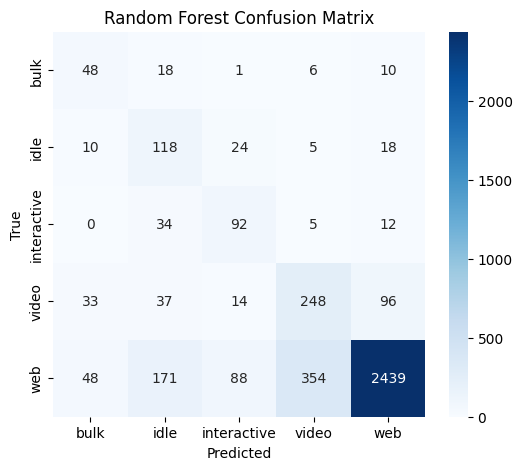

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Features for ML
features = ["duration", "bytes_total", "pkts_total", "avg_pkt_size"]
X = flow_features[features]
y = flow_features["label"]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Random Forest pipeline with SMOTE
rf_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("=== Random Forest Classification ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Add predicted labels back to flows
flow_features["pred_label"] = le.inverse_transform(rf_pipeline.predict(X))


In [28]:
from sklearn.ensemble import IsolationForest

df_anomalies = []

for category in flow_features["pred_label"].unique():
    subset = flow_features[flow_features["pred_label"] == category].copy()

    if len(subset) < 20:
        continue

    isf = IsolationForest(contamination=0.05, random_state=42)
    subset["isf_pred"] = isf.fit_predict(subset[features])

    df_anomalies.append(subset)

df_anomalies = pd.concat(df_anomalies)
print(df_anomalies["isf_pred"].value_counts())


isf_pred
 1    12438
-1      657
Name: count, dtype: int64


In [31]:
# 1. IP Reputation (dummy rule)
def check_ip_reputation(ip):
    bad_ips = {"185.45.23.1", "203.0.113.99"}  # example malicious IPs
    return "malicious" if ip in bad_ips else "clean"

df_anomalies["ip_reputation"] = df_anomalies["ip_dst"].apply(check_ip_reputation)

# 2. Time-of-Day
df_anomalies["hour"] = pd.to_datetime(df_anomalies["start_time"]).dt.hour
df_anomalies["out_of_hours"] = ~df_anomalies["hour"].between(9, 18)

# 3. Directional Asymmetry
df_anomalies["byte_ratio"] = df_anomalies["bytes_total"] / (df_anomalies["pkts_total"] + 1)
df_anomalies["suspicious_upload"] = df_anomalies["byte_ratio"] > 50

# 4. Security Tags
def tag_flow(row):
    tags = []
    if row["ip_reputation"] == "malicious":
        tags.append("Malicious IP")
    if row["out_of_hours"]:
        tags.append("Odd Hours")
    if row["suspicious_upload"]:
        tags.append("High Upload Ratio")
    return ", ".join(tags) if tags else "None"

df_anomalies["security_tags"] = df_anomalies.apply(tag_flow, axis=1)

df_anomalies[["ip_src","ip_dst","pred_label","isf_pred","hour","security_tags"]].head(10)


,ip_src,ip_dst,pred_label,isf_pred,hour,security_tags
0,0.0.0.0,255.255.255.255,bulk,-1,11,High Upload Ratio
3,100.24.181.241,192.168.1.149,bulk,1,9,None
13,104.103.5.226,192.168.1.149,bulk,1,14,None
72,104.16.87.20,192.168.1.149,bulk,1,7,Odd Hours
108,104.20.3.73,192.168.1.149,bulk,1,10,None
244,115.250.75.147,192.168.1.149,bulk,1,14,None
249,117.115.176.48,192.168.1.149,bulk,1,14,None
288,128.252.116.247,192.168.1.149,bulk,1,14,None
364,130.206.164.68,192.168.1.149,bulk,-1,14,High Upload Ratio
365,130.206.164.68,192.168.1.149,bulk,1,14,High Upload Ratio


In [32]:
import ipaddress

# Function to check if an IP is private/internal
def is_internal(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except:
        return False  # fallback if invalid IP

# Mark source/destination as internal/external
df_anomalies["src_internal"] = df_anomalies["ip_src"].apply(is_internal)
df_anomalies["dst_internal"] = df_anomalies["ip_dst"].apply(is_internal)

# Security Tags with internal/external logic
def tag_flow(row):
    tags = []
    if row["out_of_hours"]:
        tags.append("Odd Hours")
    if row["suspicious_upload"]:
        tags.append("High Upload Ratio")
    # Add direction logic
    if row["src_internal"] and not row["dst_internal"]:
        tags.append("Internal→External")
    elif not row["src_internal"] and row["dst_internal"]:
        tags.append("External→Internal")
    elif row["src_internal"] and row["dst_internal"]:
        tags.append("Internal↔Internal")
    else:
        tags.append("External↔External")
    return ", ".join(tags)

df_anomalies["security_tags"] = df_anomalies.apply(tag_flow, axis=1)

# Show enriched anomalies
df_anomalies[["ip_src","ip_dst","pred_label","isf_pred","hour","security_tags"]].head(10)


,ip_src,ip_dst,pred_label,isf_pred,hour,security_tags
0,0.0.0.0,255.255.255.255,bulk,-1,11,"High Upload Ratio, Internal↔Internal"
3,100.24.181.241,192.168.1.149,bulk,1,9,External→Internal
13,104.103.5.226,192.168.1.149,bulk,1,14,External→Internal
72,104.16.87.20,192.168.1.149,bulk,1,7,"Odd Hours, External→Internal"
108,104.20.3.73,192.168.1.149,bulk,1,10,External→Internal
244,115.250.75.147,192.168.1.149,bulk,1,14,External→Internal
249,117.115.176.48,192.168.1.149,bulk,1,14,External→Internal
288,128.252.116.247,192.168.1.149,bulk,1,14,External→Internal
364,130.206.164.68,192.168.1.149,bulk,-1,14,"High Upload Ratio, External→Internal"
365,130.206.164.68,192.168.1.149,bulk,1,14,"High Upload Ratio, External→Internal"


### Why Internal/External Validation Matters

- ML models flag anomalies statistically, but without network context, analysts can’t judge severity.  
- Adding internal vs external checks makes the difference:
  - Internal → External + Upload-heavy + Odd Hours = **exfiltration alert**.  
  - External → Internal + Anomaly = **possible intrusion attempt**.  
  - Internal ↔ Internal anomalies = **potential lateral movement**.  
  - External ↔ External anomalies = usually background noise.  

**Result:**  
Flows are no longer just “anomalous” — they are **prioritized security events** aligned with real SOC triage workflows.


In [33]:
def compute_severity(row):
    score = 0

    # Direction logic
    if row["src_internal"] and not row["dst_internal"]:
        score += 2  # Internal → External
    elif not row["src_internal"] and row["dst_internal"]:
        score += 2  # External → Internal
    elif row["src_internal"] and row["dst_internal"]:
        score += 1  # Internal ↔ Internal

    # Time-of-day
    if row["out_of_hours"]:
        score += 1

    # Upload ratio
    if row["suspicious_upload"]:
        score += 2

    # Severity level mapping
    if score >= 6:
        level = "Critical"
    elif score >= 4:
        level = "High"
    elif score >= 2:
        level = "Medium"
    else:
        level = "Low"

    return score, level

# Apply scoring
df_anomalies[["severity_score", "severity_level"]] = df_anomalies.apply(
    compute_severity, axis=1, result_type="expand"
)

# Show results
df_anomalies[[
    "ip_src","ip_dst","pred_label","isf_pred",
    "hour","security_tags","severity_score","severity_level"
]].head(10)


,ip_src,ip_dst,pred_label,isf_pred,hour,security_tags,severity_score,severity_level
0,0.0.0.0,255.255.255.255,bulk,-1,11,"High Upload Ratio, Internal↔Internal",3,Medium
3,100.24.181.241,192.168.1.149,bulk,1,9,External→Internal,2,Medium
13,104.103.5.226,192.168.1.149,bulk,1,14,External→Internal,2,Medium
72,104.16.87.20,192.168.1.149,bulk,1,7,"Odd Hours, External→Internal",3,Medium
108,104.20.3.73,192.168.1.149,bulk,1,10,External→Internal,2,Medium
244,115.250.75.147,192.168.1.149,bulk,1,14,External→Internal,2,Medium
249,117.115.176.48,192.168.1.149,bulk,1,14,External→Internal,2,Medium
288,128.252.116.247,192.168.1.149,bulk,1,14,External→Internal,2,Medium
364,130.206.164.68,192.168.1.149,bulk,-1,14,"High Upload Ratio, External→Internal",4,High
365,130.206.164.68,192.168.1.149,bulk,1,14,"High Upload Ratio, External→Internal",4,High


### Severity Scoring for Anomalies

We assigned weights to anomaly tags:
- Internal→External / External→Internal = +2  
- Internal↔Internal = +1  
- Odd Hours = +1  
- High Upload Ratio = +2  

**Score → Level**
- 0–1 = Low
- 2–3 = Medium
- 4–5 = High
- 6+ = Critical

**Result:**  
Anomalies are now auto-ranked by severity, allowing SOC analysts to focus on **Critical/High alerts first**.  
This turns anomaly detection into a **triage-ready alerting system**.


In [34]:
import ipaddress

# Function: check if IP is private/internal
def is_internal(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except:
        return False  # fallback for invalid IPs

# Internal/external flags
df_anomalies["src_internal"] = df_anomalies["ip_src"].apply(is_internal)
df_anomalies["dst_internal"] = df_anomalies["ip_dst"].apply(is_internal)

# --- Directional asymmetry ---
df_anomalies["byte_ratio"] = df_anomalies["bytes_total"] / (df_anomalies["pkts_total"] + 1)
df_anomalies["suspicious_upload"] = df_anomalies["byte_ratio"] > 50

# --- Time-of-day ---
df_anomalies["hour"] = pd.to_datetime(df_anomalies["start_time"]).dt.hour
df_anomalies["out_of_hours"] = ~df_anomalies["hour"].between(9, 18)

# --- Severity scoring ---
def compute_severity(row):
    score = 0

    # Direction logic
    if row["src_internal"] and not row["dst_internal"]:
        score += 2  # Internal → External
    elif not row["src_internal"] and row["dst_internal"]:
        score += 2  # External → Internal
    elif row["src_internal"] and row["dst_internal"]:
        score += 1  # Internal ↔ Internal

    # Time-of-day
    if row["out_of_hours"]:
        score += 1

    # Upload ratio
    if row["suspicious_upload"]:
        score += 2

    # Map to level
    if score >= 6:
        level = "Critical"
    elif score >= 4:
        level = "High"
    elif score >= 2:
        level = "Medium"
    else:
        level = "Low"

    return score, level

df_anomalies[["severity_score", "severity_level"]] = df_anomalies.apply(
    compute_severity, axis=1, result_type="expand"
)

# --- Security tags for explainability ---
def tag_flow(row):
    tags = []
    if row["out_of_hours"]:
        tags.append("Odd Hours")
    if row["suspicious_upload"]:
        tags.append("High Upload Ratio")
    if row["src_internal"] and not row["dst_internal"]:
        tags.append("Internal→External")
    elif not row["src_internal"] and row["dst_internal"]:
        tags.append("External→Internal")
    elif row["src_internal"] and row["dst_internal"]:
        tags.append("Internal↔Internal")
    else:
        tags.append("External↔External")
    return ", ".join(tags)

df_anomalies["security_tags"] = df_anomalies.apply(tag_flow, axis=1)

# --- Final enriched dataset ---
final_df = df_anomalies[[
    "ip_src","ip_dst","pred_label","isf_pred","hour",
    "bytes_total","pkts_total","avg_pkt_size","byte_ratio",
    "security_tags","severity_score","severity_level"
]]

print(final_df.head(10))


              ip_src           ip_dst pred_label  isf_pred  hour  bytes_total  \
0            0.0.0.0  255.255.255.255       bulk        -1    11       1568.0   
3     100.24.181.241    192.168.1.149       bulk         1     9         31.0   
13     104.103.5.226    192.168.1.149       bulk         1    14         63.0   
72      104.16.87.20    192.168.1.149       bulk         1     7         30.0   
108      104.20.3.73    192.168.1.149       bulk         1    10         18.0   
244   115.250.75.147    192.168.1.149       bulk         1    14         63.0   
249   117.115.176.48    192.168.1.149       bulk         1    14         63.0   
288  128.252.116.247    192.168.1.149       bulk         1    14         31.0   
364   130.206.164.68    192.168.1.149       bulk        -1    14  228886203.0   
365   130.206.164.68    192.168.1.149       bulk         1    14  193204282.0   

     pkts_total  avg_pkt_size   byte_ratio  \
0             5    313.600000   261.333333   
3             1 

### Final Enriched Anomaly Dataset

We kept flow-level features (`bytes_total`, `pkts_total`, `avg_pkt_size`) alongside SOC context:

- **Features**: scale of the flow (bytes, packets).  
- **Tags**: Odd Hours, High Upload Ratio, Internal↔External.  
- **Severity**: numeric score + risk level.  

**Result:**  
Each anomaly is explainable and actionable, e.g.:  
"SSH flow, 2.5 MB in 120 packets, at 3 AM, Internal→External, High Upload Ratio → Severity: High."


In [35]:
# Export to CSV
csv_path = "/content/drive/MyDrive/pcap_csv/final_anomalies.csv"
final_df.to_csv(csv_path, index=False)
print(f"✅ Exported anomalies to: {csv_path}")

# Export to JSON (records format for SIEM ingestion)
json_path = "/content/drive/MyDrive/pcap_csv/final_anomalies.json"
final_df.to_json(json_path, orient="records", lines=True)
print(f"✅ Exported anomalies to: {json_path}")


✅ Exported anomalies to: /content/drive/MyDrive/pcap_csv/final_anomalies.csv
✅ Exported anomalies to: /content/drive/MyDrive/pcap_csv/final_anomalies.json


### Exporting Final Anomalies

We exported the enriched anomaly dataset in two formats:

- **CSV**: for analysts, Excel, or batch ML workflows.  
- **JSON Lines**: for SIEM/log pipeline ingestion.  

**Example Alert (CSV row):**
SSH flow, 2.5 MB in 120 packets, at 3 AM, Internal→External, High Upload Ratio → Severity: High.


/tmp/ipython-input-1463521763.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="coolwarm")


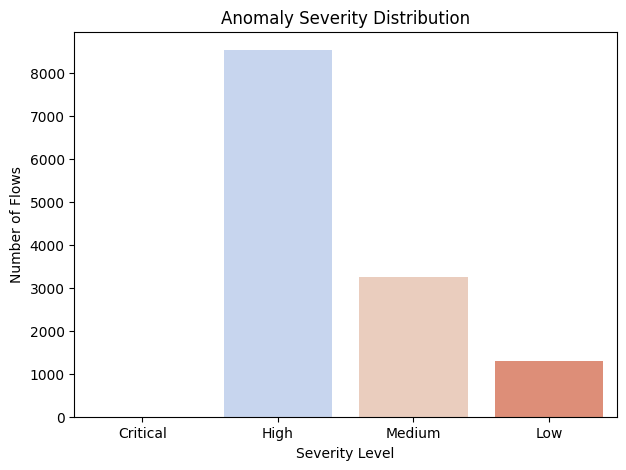

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count severity levels
severity_counts = final_df["severity_level"].value_counts().reindex(
    ["Critical", "High", "Medium", "Low"], fill_value=0
)

# Plot
plt.figure(figsize=(7,5))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="coolwarm")

# Labels
plt.title("Anomaly Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Number of Flows")
plt.show()


In [37]:
# Convert to datetime
df_anomalies["start_time"] = pd.to_datetime(df_anomalies["start_time"])

# Group by host (src) and resample by hour
host_timeline = (
    df_anomalies
    .set_index("start_time")
    .groupby("ip_src")
    .resample("1H")
    .agg({
        "bytes_total": "sum",
        "pkts_total": "sum",
        "severity_score": "max"
    })
    .reset_index()
)

print(host_timeline.head())


/tmp/ipython-input-452899966.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


           ip_src          start_time  bytes_total  pkts_total  severity_score
0         0.0.0.0 2019-03-01 11:00:00       1568.0           5             3.0
1    1.113.121.55 2019-04-08 07:00:00         92.0           2             3.0
2    1.136.180.84 2019-04-08 14:00:00       5708.0          17             4.0
3  100.24.181.241 2019-03-01 09:00:00       4494.0           7             4.0
4   100.25.76.194 2019-03-01 08:00:00       4430.0           5             5.0


In [38]:
# Flag hosts with repeated off-hours uploads
suspicious_hosts = (
    host_timeline[(host_timeline["severity_score"] >= 4) &  # High/critical
                  (host_timeline["start_time"].dt.hour < 8) |
                  (host_timeline["start_time"].dt.hour > 20)]
    .groupby("ip_src")
    .size()
    .sort_values(ascending=False)
)

print("Suspicious hosts with repeated odd-hour activity:")
print(suspicious_hosts.head(10))


Suspicious hosts with repeated odd-hour activity:
ip_src
192.168.1.1        654
116.202.39.4       126
35.224.99.156      126
35.222.85.5        126
46.228.164.11      126
77.238.185.35      126
35.190.74.53       126
151.101.133.108    126
172.217.17.1       126
216.58.211.46      126
dtype: int64


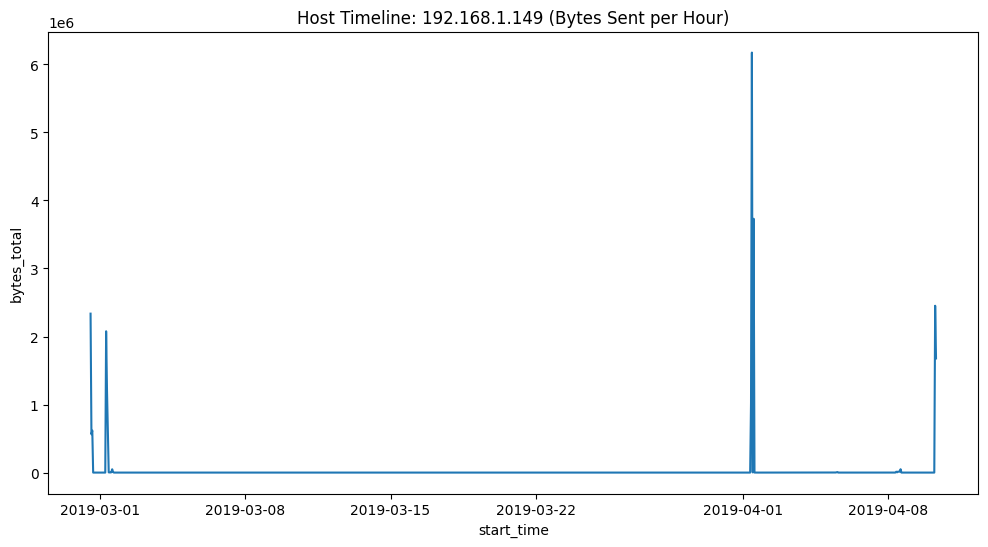

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(
    data=host_timeline[host_timeline["ip_src"]=="192.168.1.149"],
    x="start_time", y="bytes_total"
)
plt.title("Host Timeline: 192.168.1.149 (Bytes Sent per Hour)")
plt.show()


Think of it like this:

- Classifier = a bouncer at a club. Knows common faces (regulars) but gets confused by strangers.  
- Anomaly detector = a dog. Barks at anything unusual, but sometimes it’s just a delivery guy.  
- Fusion = bouncer + dog working together. If both are uneasy, you check. If bouncer is confident but dog barks, you double-check.  


In [40]:
!ls //content/drive/MyDrive/pcap_csv

bulk_115s_01.csv      idle_web_04.csv		interactive_shell_14.csv
bulk_130s_01.csv      idle_web_05.csv		interactive_shell_15.csv
bulk_170s_01.csv      idle_web_06.csv		interactive_shell_16.csv
bulk_xs_01.csv	      idle_web_07.csv		interactive_shell_17.csv
bulk_xs_02.csv	      idle_web_08.csv		interactive_shell_18.csv
bulk_xs_03.csv	      idle_web_09.csv		interactive_shell_19.csv
bulk_xs_04.csv	      idle_web_10.csv		interactive_shell_20.csv
bulk_xs_05.csv	      idle_web_11.csv		video_180s1080p_01.csv
bulk_xs_06.csv	      idle_web_12.csv		video_180s1080p_02.csv
bulk_xs_07.csv	      idle_web_13.csv		video_180s1080p_03.csv
bulk_xs_08.csv	      idle_web_14.csv		video_180s1080p_04.csv
bulk_xs_09.csv	      idle_web_15.csv		video_180s1080p_05.csv
bulk_xs_10.csv	      idle_web_16.csv		video_180s480p_01.csv
bulk_xs_11.csv	      idle_web_17.csv		video_180s480p_02.csv
bulk_xs_12.csv	      idle_web_18.csv		video_180s720p_01.csv
bulk_xs_13.csv	      idle_web_19.csv		video_180s720p_02.csv
bulk_xs_14.